In [1]:
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")
import platform

%load_ext autoreload
%autoreload 2

In [2]:
from kalman_steps import *

In [3]:
comp_id = platform.node()
data_id = 1 if comp_id=="dg-MS-7917" else (6 if comp_id=="doga-yg" else 0)
gpx_obj, segment = step_01_load_data(data_id)

/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/activity_11238879870.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/hh_marathon.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/activity_11238893125_basak02.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/activity_11212422262.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/3-laender-giro_cleaned.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/3-laender-giro.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/activity_11231936537_basak01.gpx
Loading file: /home/dgy/GitHubUbuntU/gps_data_with_python/gpx/activity_11231936537_basak01.gpx
num of tracks=1


### Let's try to correct some unrealistic things like

In [4]:
segment.get_uphill_downhill()

UphillDownhill(uphill=303.55997962951676, downhill=307.7599842071533)

### ... and speed records on a bikecycle

Training started on 30th of May 2023 at 15:00PM.
Pause point at index 52: Activity time so far: 2'57" seconds
Pause point at index 322: Activity time so far: 18'41" seconds
Pause point at index 489: Activity time so far: 29'51" seconds
Pause point at index 736: Activity time so far: 44'48" seconds
Pause point at index 839: Activity time so far: 49'32" seconds
Pause point at index 1006: Activity time so far: 1:4'15" seconds
Pause point at index 1055: Activity time so far: 1:8'9" seconds
Pause point at index 1134: Activity time so far: 1:12'39" seconds
Pause point at index 1235: Activity time so far: 1:19'14" seconds
Pause point at index 1245: Activity time so far: 1:20'27" seconds
Pause point at index 1468: Activity time so far: 1:32'24" seconds
Pause point at index 1571: Activity time so far: 1:39'16" seconds


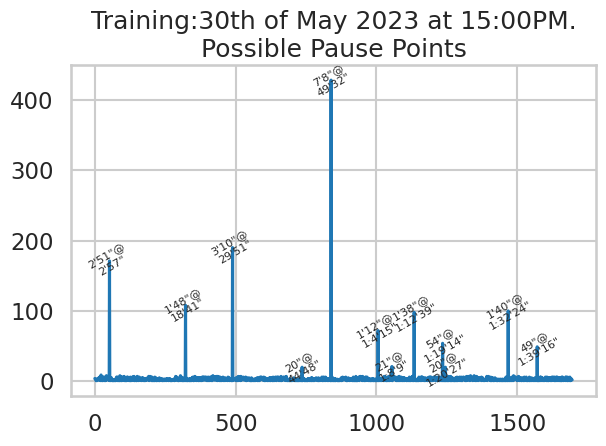

In [18]:
possible_pause_idx = step_xx0_find_possible_pause_points(segment, min_pause_time=10, verbose=1, plot_level=1)

In [ ]:
speed_dict = {}
step_02_initial_speed(gpx_obj, segment, speed_dict)

In [ ]:
plot_all_keys(speed_dict)
plot_all_key_difs(speed_dict)

### But we start with a little bit of data wrangling

In [ ]:
coords = step_03_segments_to_coords_pd(segment)
print(coords.head())
print(coords.tail())

### Oh... time interval is not always 1sec, let's do something about that and round to nearest sec

In [ ]:
step_04_round_time(coords)
coords.tail()

### Do we have signal loss?

In [ ]:
plt.hist(np.abs(np.diff(coords.index).astype('timedelta64[s]').astype(float)), bins=30);

### Okay, let's resample with 1 sec intevals and fill up with NaN

In [ ]:
coords = step_05_resample(coords=coords, freq='1s')

In [ ]:
coords.loc[coords.ele.isnull()].head()
plt.hist(np.diff(coords.index).astype('timedelta64[s]').astype(float));

### Almost done. Now convert to good old numpy array and mask NaNs

In [ ]:
measurements = step_06_get_measurements_from_coords(coords) # lon-0 lat-1 ele-2

### So where did I lose the GPS signal?

In [ ]:
coords, original_coords_idx = step_07_fill_nan_values(coords, measurements, 2)

### Let's set up the Kalman Filter

In [ ]:
kf, kf_dict = step_08_setup_kalman_filter(measurements)

### Compare now our measurements with a smoothed track

In [ ]:
state_means, state_vars = step_09_apply_kalman(kf, measurements)

In [ ]:
step_10_plot_smoothed_vs_measured(state_means, measurements)

### Let's write the smoothed data back into our dataframe and GPX file

In [ ]:
coords, orig_coords = step_11_15_22_update_coords(state_means, coords, segment, original_coords_idx)

In [ ]:
segment.get_uphill_downhill()

### Yes, that sounds much more realistic!!! Let's also check the speed

In [ ]:
speed = step_12_16_23_add_missing_speeds(gpx_obj, segment, speed_dict, 'speed_1_after_kalman', plot_after_add=True)

### Arrrggh!!! Still not good! What the heck is going on?

In [ ]:
plot_all_key_difs(speed_dict)

In [ ]:
high_speed_block = step_13_get_high_speed_block(speed, measurements, segment, plot_result=True, verbose=False)

### Here we have one of the hyperspeed points, so what happens here? Points seem to stack...

### Looking at these numbers the sensors seems to be quite inert! Let's just eliminate unlikely points and their surroundings by using the covariance given by the Kalman filter!

In [ ]:
measurements, bad_readings = step_14_find_bad_readings_from_variance(measurements, state_vars, verbose=True)

In [ ]:
state_means, state_vars = kf.smooth(measurements)

### Write it back our GPX file again

In [ ]:
coords, orig_coords = step_11_15_22_update_coords(state_means, coords, segment, original_coords_idx)

In [ ]:
speed = step_12_16_23_add_missing_speeds(gpx_obj, segment, speed_dict, 'speed_2_add_missing', plot_after_add=True)

### We are getting there! Let's take a look where the problem is...

In [ ]:
step_17_21_calc_speed_with_corrected_positions(state_means, speed_dict, "speed_3_after_calc", measurements, high_speed_block, verbose=False, plot_result=2)

### mmhhh.. okay, that's hard. The GPS sensor has fallen behind in a curve, followed by "normal" readings then has caught up with the actual position

In [ ]:
outliers_idx = step_18_check_for_outliers_by_strong_accelerations(speed_dict["speed_3_after_calc"], measurements, plot_result=True)

### Okay, let's just remove those points with surroundings and let Kalman do the rest

In [ ]:
state_means, state_vars, measurements = step_19_mask_around_outliers(kf, measurements, outliers_idx, neighbour_cnt=12)

In [ ]:
state_means, state_vars = step_20_apply_kalman(state_means, state_vars, kf, n_times=20)

In [ ]:
step_17_21_calc_speed_with_corrected_positions(state_means, speed_dict, "speed_4_after_calc20", measurements, high_speed_block, verbose=False, plot_result=1)

In [ ]:
plot_all_keys(speed_dict,fr_to=[min(high_speed_block),max(high_speed_block)])
#plt.plot(speed_dict["speed_4_after_calc20"][min(use_sub_arr):max(use_sub_arr)], '.')

In [ ]:
plt.plot(measurements[high_speed_block,0], measurements[high_speed_block,1], 'ro', label='measured', markersize=10)
plt.plot(state_means[high_speed_block,0], state_means[high_speed_block,1], 'g.',label='smoothed', markersize=8)
plt.legend()
plt.show()

In [ ]:
coords, orig_coords = step_11_15_22_update_coords(state_means, coords, segment, original_coords_idx)

In [ ]:
segment.get_uphill_downhill()

### Finally, write everything back to the GPX file

In [ ]:
speed = step_12_16_23_add_missing_speeds(gpx_obj, segment, speed_dict, 'speed_5_after_final', plot_after_add=True)

In [ ]:
plot_all_key_difs(speed_dict)

In [ ]:
step_10_plot_smoothed_vs_measured(state_means, measurements)

1- kalman filtreye girdiğinde state_means üzerinden distance toplamına odaklan\n
   ne kadar değişiyor her iiterasyonda \n
2- aynı zamanda elevation da\n
   elevation smooth ettikçe azalıyor - bir hata var o işte\n
3- bir de elevation bilgisini gps bilgisinden alma vardı. o nerede?\n
4- niye 3600 elemanlı veri var? 

In [ ]:
#with open('../gpx/3-laender-giro_cleaned.gpx', 'w') as fh:
#    fh.write(gpx_file.to_xml())